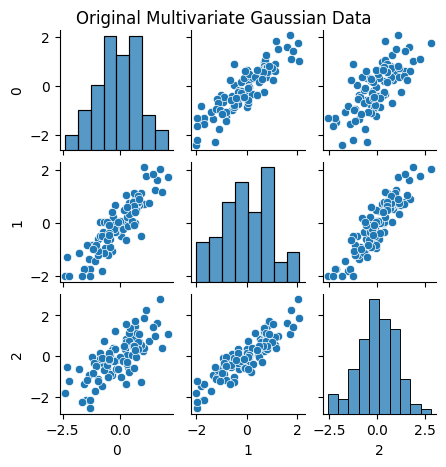

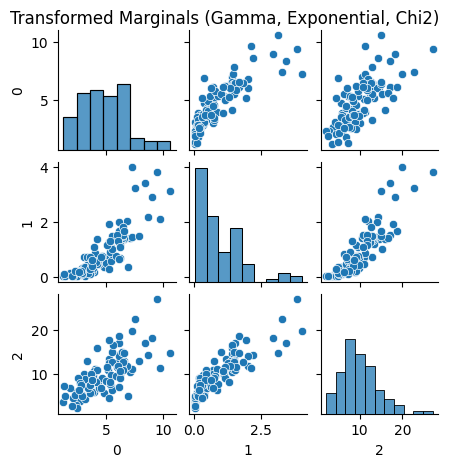

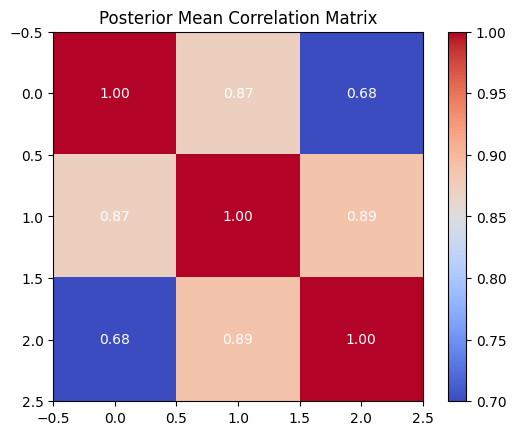

In [21]:
#Q1.2
import numpy as np
from scipy import stats
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Simulate multivariate Gaussian data
p = 3
n = 100
true_corr = (np.ones((p, p)) * 9 + np.diag((1, 1, 1))) / 10
true_corr[0, 2] -= 0.15
true_corr[2, 0] -= 0.15

X = stats.multivariate_normal(mean=np.zeros(p), cov=true_corr).rvs(size=n)

# Plot original Gaussian data
sns.pairplot(pd.DataFrame(X), height=1.5)
plt.suptitle("Original Multivariate Gaussian Data", y=1.02)
plt.show()

# Transform marginals
Y = X.copy()
Y[:, 0] = stats.gamma(a=5).ppf(stats.norm().cdf(X[:, 0]))
Y[:, 1] = stats.expon(scale=1).ppf(stats.norm().cdf(X[:, 1]))
Y[:, 2] = stats.chi2(df=10).ppf(stats.norm().cdf(X[:, 2]))

# Plot transformed marginals
sns.pairplot(pd.DataFrame(Y), height=1.5)
plt.suptitle("Transformed Marginals (Gamma, Exponential, Chi2)", y=1.02)
plt.show()

# Fit marginal models (First pass)
traces = {}
param_means = []

# Marginal 1: Gamma
with pm.Model() as model_gamma:
    alpha = pm.HalfNormal("alpha", sigma=10)
    obs1 = pm.Gamma("obs1", alpha=alpha, beta=1, observed=Y[:, 0])
    traces["gamma"] = pm.sample(1000, tune=1000, progressbar=False, cores=1)
    param_means.append(az.summary(traces["gamma"], var_names=["alpha"])["mean"].values[0])

# Marginal 2: Exponential
with pm.Model() as model_exp:
    lam = pm.HalfNormal("lam", sigma=10)
    obs2 = pm.Exponential("obs2", lam=lam, observed=Y[:, 1])
    traces["exp"] = pm.sample(1000, tune=1000, progressbar=False, cores=1)
    param_means.append(az.summary(traces["exp"], var_names=["lam"])["mean"].values[0])

# Marginal 3: Chi-squared
with pm.Model() as model_chi2:
    df = pm.HalfNormal("df", sigma=10)
    obs3 = pm.ChiSquared("obs3", nu=df, observed=Y[:, 2])
    traces["chi2"] = pm.sample(1000, tune=1000, progressbar=False, cores=1)
    param_means.append(az.summary(traces["chi2"], var_names=["df"])["mean"].values[0])

# Convert to pseudo-observations
z0 = stats.norm.ppf(stats.gamma(a=param_means[0], scale=1).cdf(Y[:, 0]))
z1 = stats.norm.ppf(stats.expon(scale=1 / param_means[1]).cdf(Y[:, 1]))
z2 = stats.norm.ppf(stats.chi2(df=param_means[2]).cdf(Y[:, 2]))
Z = np.column_stack([z0, z1, z2])

# Estimate copula correlation matrix (Second pass)
with pm.Model() as copula_model:
    L, corr_matrix, _ = pm.LKJCholeskyCov("copula", n=3, eta=2.0,
                                          sd_dist=pm.Exponential.dist(1.0, shape=3),
                                          compute_corr=True)
    copula_obs = pm.MvNormal("Z_obs", mu=np.zeros(3), chol=L, observed=Z)
    copula_trace = pm.sample(1000, tune=1000, progressbar=False, cores=1)

# Plot posterior mean correlation matrix
R_mean = copula_trace.posterior["copula_corr"].mean(dim=["chain", "draw"]).values
fig, ax = plt.subplots()
im = ax.imshow(R_mean, cmap="coolwarm", vmin=0.7, vmax=1.0)
for i in range(3):
    for j in range(3):
        ax.text(j, i, f"{R_mean[i, j]:.2f}", ha="center", va="center", color="white")
plt.colorbar(im, ax=ax)
plt.title("Posterior Mean Correlation Matrix")
plt.show()


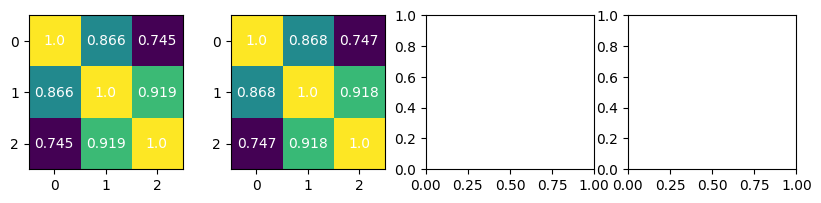

In [18]:
fig, ax = plt.subplots(1, 4, figsize=(10, 2))
for i, c in enumerate(list(copula_trace.posterior["copula_corr"].values.mean(axis=1))):
    ax[i].imshow(c)
    for k in range(3):
        for j in range(3):
            ax[i].text(j, k, str(round(c[j, k], 3)),
                       color='w', va='center', ha='center')


##Q1.3
A copula is a function that links univariate marginal distribution functions to form a full multivariate distribution, thereby separating the modeling of marginals from the dependency structure. It allows the joint distribution of multiple random variables to be expressed as a combination of their individual (marginal) distributions and a correlation structure.\
One-pass model (joint modeling):
  - This approach jointly estimates the marginal parameters and the copula (correlation structure) in a single model.
  - The raw data is transformed to a Gaussian scale via deterministic transformations .
  - While this method fully propagates uncertainty between marginals and the dependency structure, it is often computationally inefficient, leading to slow sampling and convergence problems .

Two-pass model (modular estimation):
  - Each marginal is estimated separately, and the resulting posterior means are used to transform the data into pseudo-observations in a standard normal space.
  - In a second model, a Gaussian copula  is used to estimate the latent correlation matrix.
  - This approach is much more efficient and more stable, but it does not propagate uncertainty from the marginal estimation into the dependency estimation.

In summary, the joint  model is theoretically more principled but computationally expensive. The two-pass model is computationally feasible and widely used, even though it relies on point estimates for the marginals.




##Q1.4
The two-pass copula approach is particularly powerful for constructing multivariate generalized linear models (GLMs), especially when the outcome variables follow different distributional forms. In this framework, each response variable is first modeled independently using an appropriate GLM, with its own likelihood function, link function, and potentially unique covariates. Once the marginals are fitted, the residuals or predictions from each GLM are transformed to a common scale by applying their respective posterior cumulative distribution functions (CDFs), followed by the inverse CDF of a standard normal distribution. This process yields pseudo-observations that lie in a standard Gaussian space. A multivariate normal copula is then fitted to these pseudo-observations, often with an LKJ prior on the correlation matrix, to estimate the joint dependency structure among the outcomes.

This copula-based construction enables researchers to flexibly build complex multivariate models that account for both individual outcome behavior and their interdependencies, while still leveraging full Bayesian inference for uncertainty quantification. Compared to a one-pass joint model, the two-pass method is generally more scalable, interpretable, and computationally practical, particularly in high-dimensional settings or when modeling heterogeneous outcomes.


Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
ERROR:pymc.stats.convergence:There were 891 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

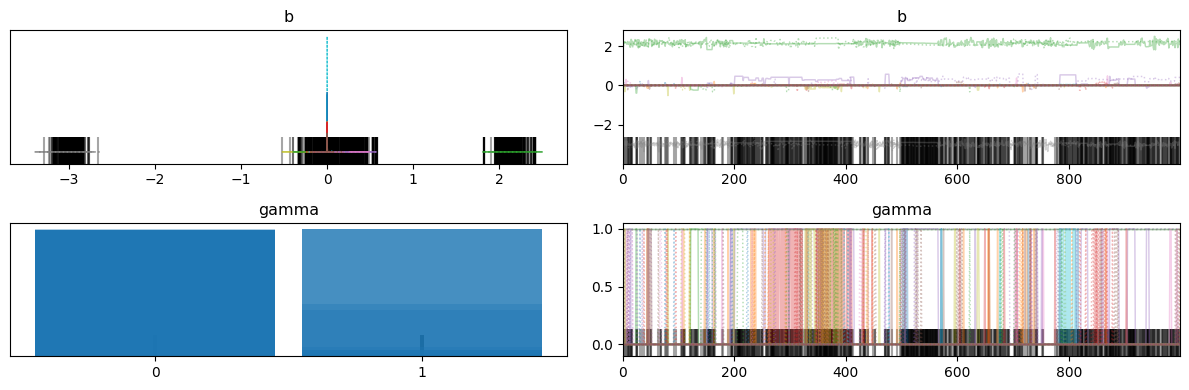

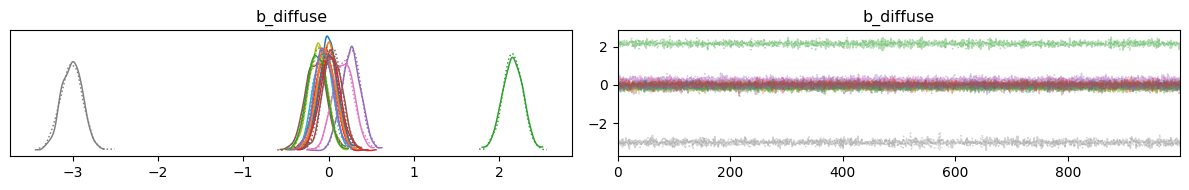

In [28]:
#Q2
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(111)

# Define data dimensions for simulation
n = 80    # Fewer observations for computational efficiency
p = 8     # Number of predictor variables
m = 2     # Number of outcome variables

# Simulate input features
X = np.random.normal(0, 1, (n, p))

# Define ground truth coefficients (sparse structure)
true_b = np.zeros((p, m))
true_b[1, 0] = 2.0
true_b[3, 1] = -3.0

# Generate response variables with added noise
Y = X @ true_b + np.random.normal(0, 1, (n, m))

# Spike-and-Slab Bayesian Model
with pm.Model() as spike_slab:
    # Inclusion mask for each coefficient
    gamma = pm.Bernoulli("gamma", p=0.5, shape=(p, m))
    # Coefficients when included
    b_slab = pm.Normal("b_slab", mu=0, sigma=10, shape=(p, m))
    # Final coefficients with selection
    b = pm.Deterministic("b", gamma * b_slab)

    # Noise standard deviation for responses
    sigma = pm.HalfNormal("sigma", sigma=1, shape=m)
    mu = pm.math.dot(X, b)
    pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

    idata_spike = pm.sample(1000, tune=1000, cores=1, random_seed=111)

#  Diffuse Normal Prior Model (No variable selection)
with pm.Model() as diffuse:
    # Coefficients with vague priors
    b_diffuse = pm.Normal("b_diffuse", mu=0, sigma=1000, shape=(p, m))
    sigma_d = pm.HalfNormal("sigma_d", sigma=1, shape=m)
    mu = pm.math.dot(X, b_diffuse)
    pm.Normal("Y_obs_d", mu=mu, sigma=sigma_d, observed=Y)

    idata_diffuse = pm.sample(1000, tune=1000, cores=1, random_seed=111)

# Plot and Compare Results
az.plot_trace(idata_spike, var_names=["b", "gamma"])
plt.tight_layout()
plt.show()

az.plot_trace(idata_diffuse, var_names=["b_diffuse"])
plt.tight_layout()
plt.show()


Output()

ERROR:pymc.stats.convergence:There were 605 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
ERROR:pymc.stats.convergence:There were 471 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


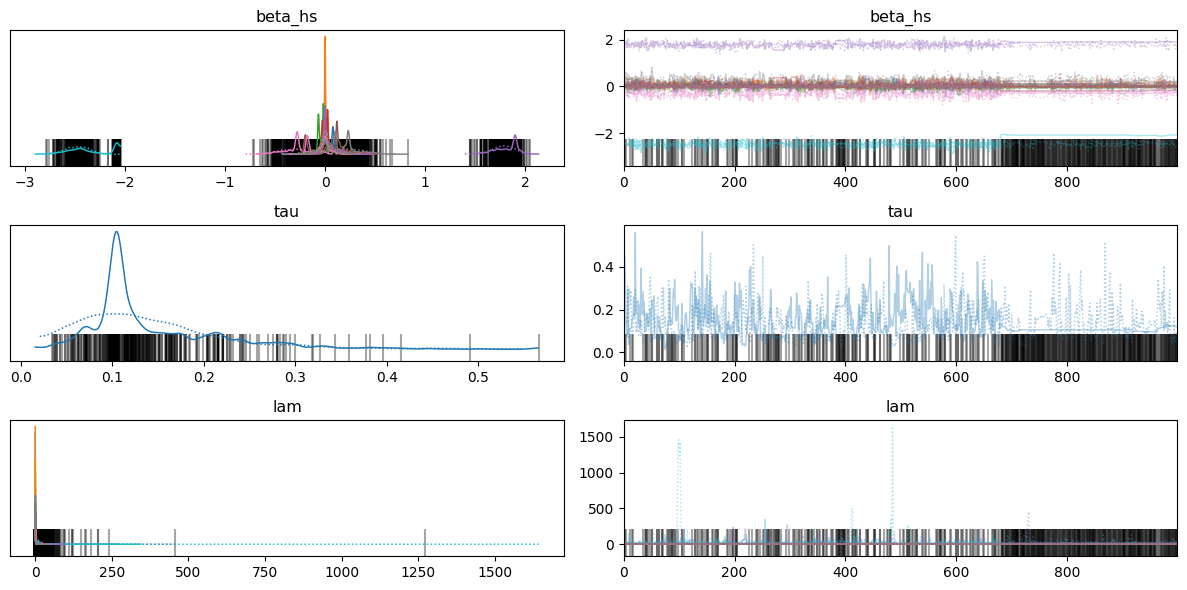

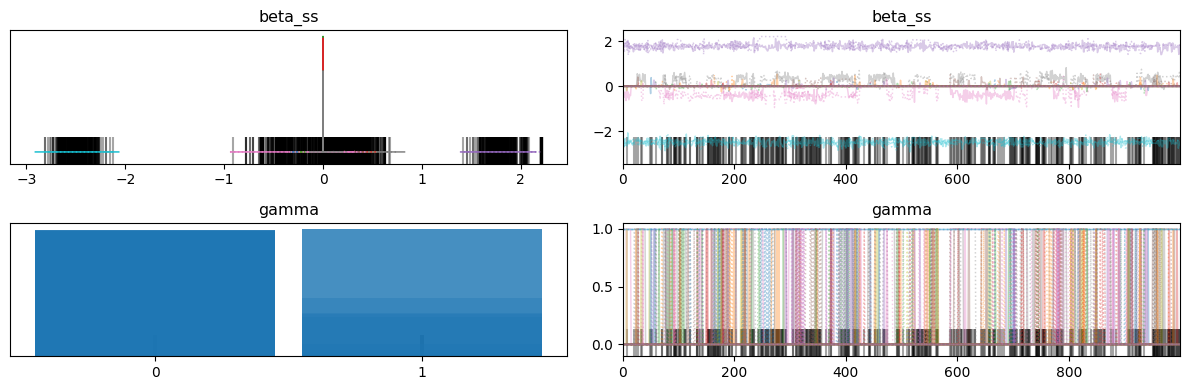

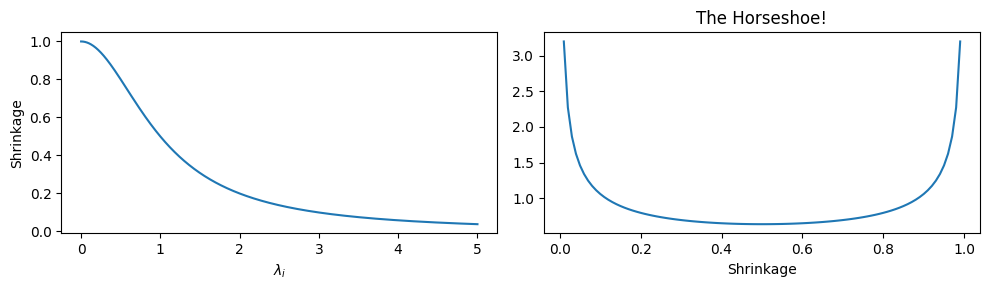

In [27]:
#Q3
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy import stats

# Set seed for reproducibility
np.random.seed(42)

# Define smaller-scale data
n = 70   # number of observations
p = 9    # number of predictors
m = 2    # number of response variables

# Simulate input features and true coefficients
X = np.random.normal(0, 1, (n, p))
true_beta = np.zeros((p, m))
true_beta[2, 0] = 1.8
true_beta[4, 1] = -2.5
Y = X @ true_beta + np.random.normal(0, 1, (n, m))

#  Horseshoe Prior Model
with pm.Model() as horseshoe_model:
    tau_prior = 1.0
    tau = pm.HalfCauchy('tau', beta=tau_prior)
    lam = pm.HalfCauchy('lam', beta=1, shape=(p, m))
    beta_hs = pm.Normal('beta_hs', mu=0, sigma=tau * lam, shape=(p, m))

    sigma = pm.HalfNormal('sigma', sigma=1, shape=m)
    mu = pm.math.dot(X, beta_hs)
    pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)

    trace_hs = pm.sample(1000, tune=1000, cores=1, random_seed=42)

#  Spike-and-Slab Model
with pm.Model() as spike_slab_model:
    gamma = pm.Bernoulli('gamma', p=0.5, shape=(p, m))
    slab = pm.Normal('slab', mu=0, sigma=10, shape=(p, m))
    beta_ss = pm.Deterministic('beta_ss', gamma * slab)

    sigma_ss = pm.HalfNormal('sigma_ss', sigma=1, shape=m)
    mu_ss = pm.math.dot(X, beta_ss)
    pm.Normal('Y_obs_ss', mu=mu_ss, sigma=sigma_ss, observed=Y)

    trace_ss = pm.sample(1000, tune=1000, cores=1, random_seed=42)

#  Visual Comparison of Traces
az.plot_trace(trace_hs, var_names=['beta_hs', 'tau', 'lam'])
plt.tight_layout()
plt.show()

az.plot_trace(trace_ss, var_names=['beta_ss', 'gamma'])
plt.tight_layout()
plt.show()

#  Horseshoe Shrinkage Visualization
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
support = np.linspace(0, 5, 1000)
shrink_1 = 1 / (1 + support**2)
ax[0].plot(support, shrink_1)
ax[0].set_ylabel("Shrinkage")
ax[0].set_xlabel("$\\lambda_i$")

shrinkage_vals = np.linspace(0.01, 0.99, 99)
jacobian = 0.5 * (1/shrinkage_vals - 1)**(-0.5) * shrinkage_vals**(-2)
density = stats.halfcauchy(scale=1).pdf((1/shrinkage_vals - 1)**0.5) * jacobian
ax[1].plot(shrinkage_vals, density)
ax[1].set_title("The Horseshoe!")
ax[1].set_xlabel("Shrinkage")
plt.tight_layout()
plt.show()


In this task, we compared two popular Bayesian variable selection techniques—Horseshoe prior and Spike-and-Slab prior—in a multivariate regression setting.

Using a synthetic dataset with 70 observations, 9 predictors, and 2 response variables, we implemented both models in PyMC. The Horseshoe model applies global-local shrinkage through half-Cauchy priors, encouraging sparsity while allowing large coefficients to escape shrinkage. The Spike-and-Slab model uses binary inclusion indicators to determine whether each coefficient is active or not.

Trace plots show that the Horseshoe prior induces more continuous shrinkage on irrelevant predictors, while Spike-and-Slab generates sharper selection decisions through binary switches.

Additionally, the shrinkage behavior of the Horseshoe prior is visualized through a change-of-variable transformation, highlighting its density near zero and heavy tails, which makes it both aggressive in shrinking noise and permissive for true signals.This comparison demonstrates how each approach handles sparsity differently and offers insight into choosing priors depending on the structure and dimensionality of the data.
